In [147]:
import nifty8 as ift
import resolve as rve
import numpy as np
import matplotlib.pyplot as plt
import configparser
import sys

In [148]:
from src.sky_model import sky_model_diffuse
from src.cal_model import gain_ops, Dterm_ops, Const_Dterm_ops, Const_Dterm_ops_normal, get_field_rotation_angle_field, pol_cal_op_RR, pol_cal_op_RL, pol_cal_op_LR, pol_cal_op_LL
from src.likelihoods import likelihood_pol, PolarizationLikelihood, PolarizationLikelihood_combined
from src.utilities import get_BeginTime_UTC

### Using config file

In [149]:
cfg = configparser.ConfigParser()
cfg.read("conf_polcal.cfg")
cfg_base = cfg["base"]
nthreads_nifty = cfg_base.getint("ntherads_ift")

In [150]:
cfg_observation = cfg["observation"]
data_path = cfg_observation["data_path"]
spectral_window = cfg_observation.getint("spectral_window")
polarizations = cfg_observation["polarizations"]
error_budget = cfg_observation.getfloat("error_budget")
parang_corrected = cfg_observation.getboolean("parang_corrected")

### Importing data in ms format

In [151]:
obs = rve.ms2observations(data_path, "DATA", True, spectral_window, polarizations)[0]
obs = obs.to_double_precision()
tmin, tmax = rve.tmin_tmax(obs)
obs = obs.move_time(-tmin)
uantennas = rve.unique_antennas(obs)
antenna_dct = {aa: ii for ii, aa in enumerate(uantennas)}
station_table = obs._auxiliary_tables['ANTENNA']['STATION']

Work on Field 0: 1226+023


In [152]:
# print the observation object
print(obs)

Observation:
  Source name:		1226+023
  Visibilities shape:	(4, 7404, 1)
  # visibilities:	29616
  Frequency range:	15239.875 -- 15239.875 MHz
  Polarizations:	RR, RL, LR, LL
  Shortest baseline:	236619.4 m -> 0.000 deg
  Longest baseline:	8611233.1 m -> 0.000 arcsec
  Flagged:		5.4%


In [153]:
# print the visibility array
print(obs.vis)

nifty8.Field instance
- domain      = DomainTuple, len: 3
* PolarizationSpace(polarization_labels=('RR', 'RL', 'LR', 'LL'))
* UnstructuredDomain(shape=(7404,))
* UnstructuredDomain(shape=(1,))
- val         = array([[[ 4.20314217e+00+1.89425573e-02j],
        [-1.92569733e+00+5.07524109e+00j],
        [ 3.00432086e+00-4.26717773e-02j],
        ...,
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [ 8.08172131e+00-5.21673679e-01j]],

       [[-5.21255657e-02-1.50790691e-01j],
        [ 6.13454990e-02-3.01652402e-03j],
        [-4.42205276e-03+4.46531288e-02j],
        ...,
        [ 0.00000000e+00+0.00000000e+00j],
        [ 0.00000000e+00+0.00000000e+00j],
        [-2.63980359e-01+1.11997969e-01j]],

       [[ 3.29444617e-01+2.35914782e-01j],
        [-4.84572470e-01-2.13033661e-01j],
        [-3.21166664e-02+1.22871749e-01j],
        ...,
        [-3.94137762e-02-1.09789290e-01j],
        [ 6.26991466e-02-1.56167790e-01j],
        [ 1.37129

### Adding systematic error budget

In [154]:
### adding systematic error budget
weight_old = obs.weight.val
new_weight = 1 / ((1 / np.sqrt(weight_old)) ** 2 + (
            error_budget * abs(obs.vis.val)) ** 2)  # 1/ (sigma**2 + (sys_error_percentage*|A|)**2)
obs._weight = new_weight
print(f"We add the systematic error budget {error_budget*1e2}%")

We add the systematic error budget 5.0%


/tmp/ipykernel_11519/940067845.py:3: RuntimeWarning: divide by zero encountered in divide
  new_weight = 1 / ((1 / np.sqrt(weight_old)) ** 2 + (


### Plots for the data

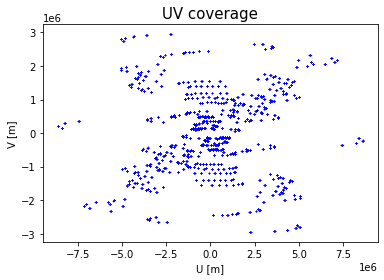

In [155]:
#UV coverage
plt.plot()
plt.scatter(obs.uvw[:,0], obs.uvw[:,1], s=0.1, color='b')
plt.scatter(-1*obs.uvw[:,0], -1*obs.uvw[:,1], s=0.1, color='b')
plt.title('UV coverage', fontsize=15)
plt.xlabel('U [m]')
plt.ylabel('V [m]')
plt.show()

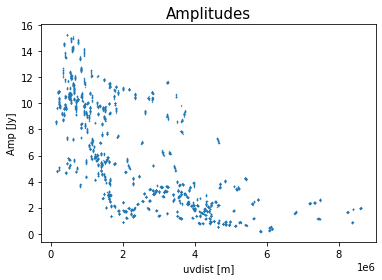

In [156]:
#radplot
uvdist = np.sqrt(obs.uvw[:,0]**2 + obs.uvw[:,1]**2)
amp_I = (abs(obs.vis.val[0,:,0]) + abs(obs.vis.val[3,:,0]))/2
phase_I = (np.angle(obs.vis.val[0,:,0], deg=True) + np.angle(obs.vis.val[3,:,0], deg=True))/2

plt.scatter(uvdist, amp_I, s=0.1)
plt.title('Amplitudes', fontsize=15)
plt.xlabel('uvdist [m]')
plt.ylabel('Amp [Jy]')
plt.show()

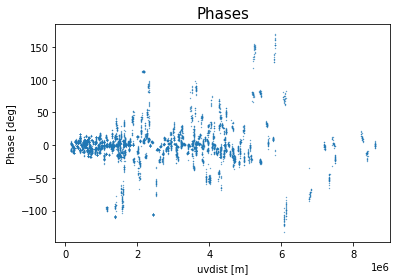

In [157]:
plt.scatter(uvdist, phase_I, s=0.1)
plt.title('Phases', fontsize=15)
plt.xlabel('uvdist [m]')
plt.ylabel('Phase [deg]')
plt.show()

### Sky prior model

In [158]:
npix_x = cfg["sky"].getint("space npix x")
npix_y = cfg["sky"].getint("space npix y")
fov_x = cfg["sky"]["space fov x"]
fov_y = cfg["sky"]["space fov y"]

fov = np.array([rve.str2rad(fov_x), rve.str2rad(fov_y)])
npix = np.array([npix_x, npix_y])
sdom = ift.RGSpace(npix, fov / npix)
pdom = rve.PolarizationSpace(["I", "Q", "U", "V"])
position_space = rve.default_sky_domain(pdom=pdom, sdom=sdom)

print(f"Number of pixels : {npix_x} x {npix_y}")
print(f"Field of view : {fov_x} x {fov_y}")

Number of pixels : 256 x 256
Field of view : 50mas x 50mas


In [159]:
#change the number of pixels and field of view
cfg["sky"]["space npix x"] = "256"
cfg["sky"]["space npix y"] = "256"
cfg["sky"]["space fov x"] = "50mas"
cfg["sky"]["space fov y"] = "50mas"

In [160]:
#calculate the offset mean from total flux (mean sky flux [Jy/str] = exp(zero mode offset))
total_flux = np.max(abs(obs.vis.val))
print(f"Total flux : {total_flux}")
offset_mean = np.log(total_flux / rve.str2rad(fov_x) / rve.str2rad(fov_y))
print(f"Stokes I zero mode offset : {np.round(offset_mean)}")
cfg["sky"]["stokesI diffuse space i0 zero mode offset"] = f"{np.round(offset_mean)}"

Total flux : 15.666216521546037
Stokes I zero mode offset : 33.0


In [161]:
sky_diffuse, logsky, additional_operators = sky_model_diffuse(cfg["sky"]) # logsky : a,b,c,d prior
sky = sky_diffuse

### Sky priors

Stokes I, Q, U, and V priors 1


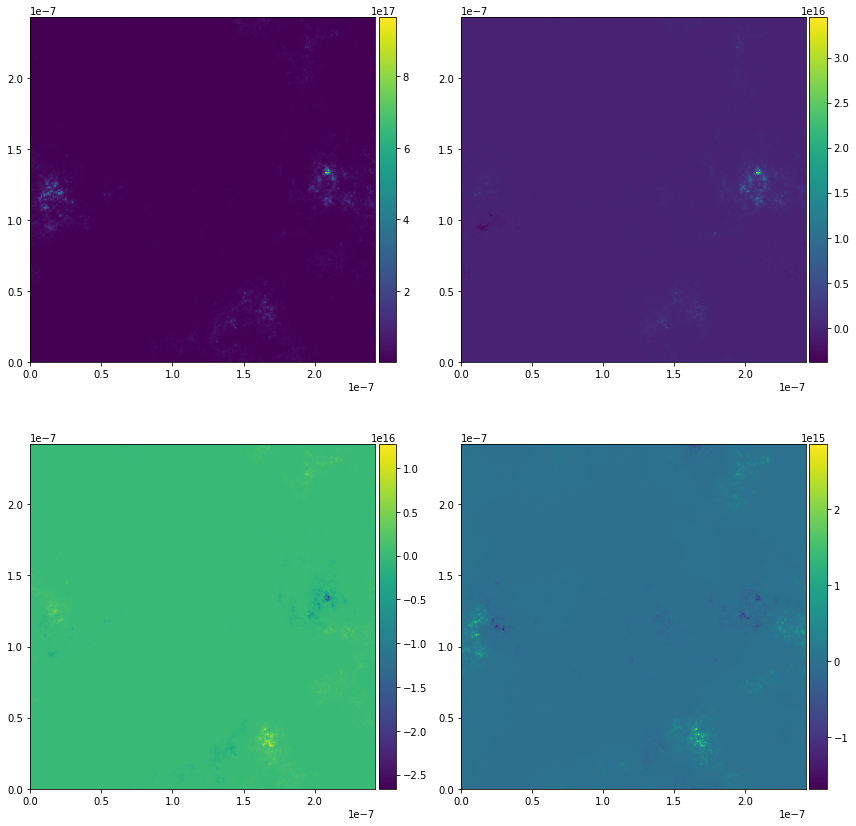

Stokes I, Q, U, and V priors 2


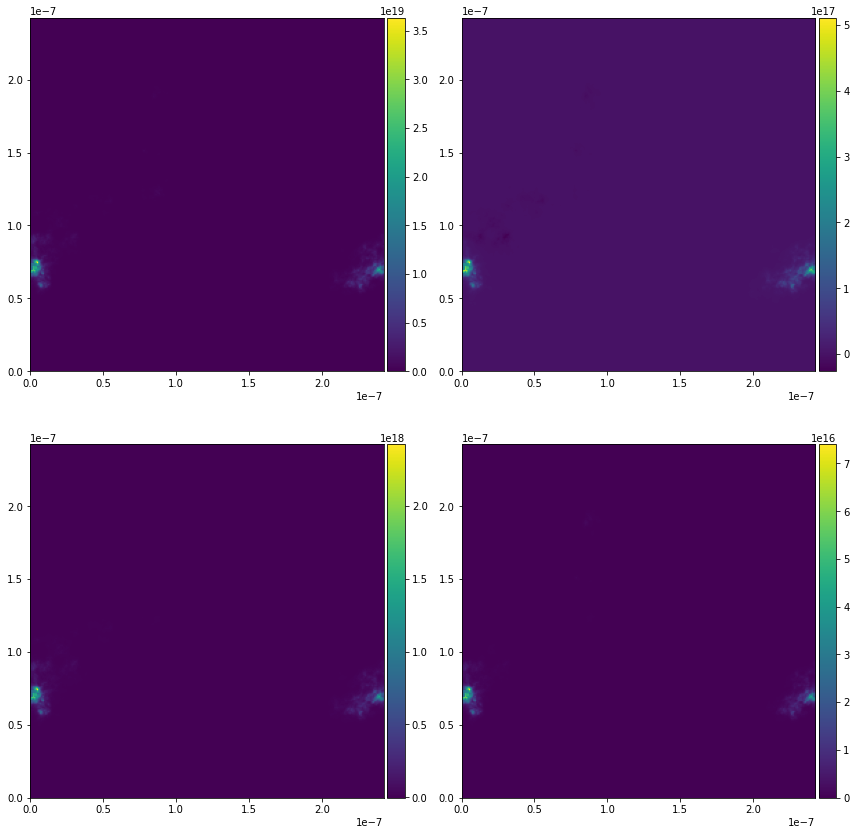

Stokes I, Q, U, and V priors 3


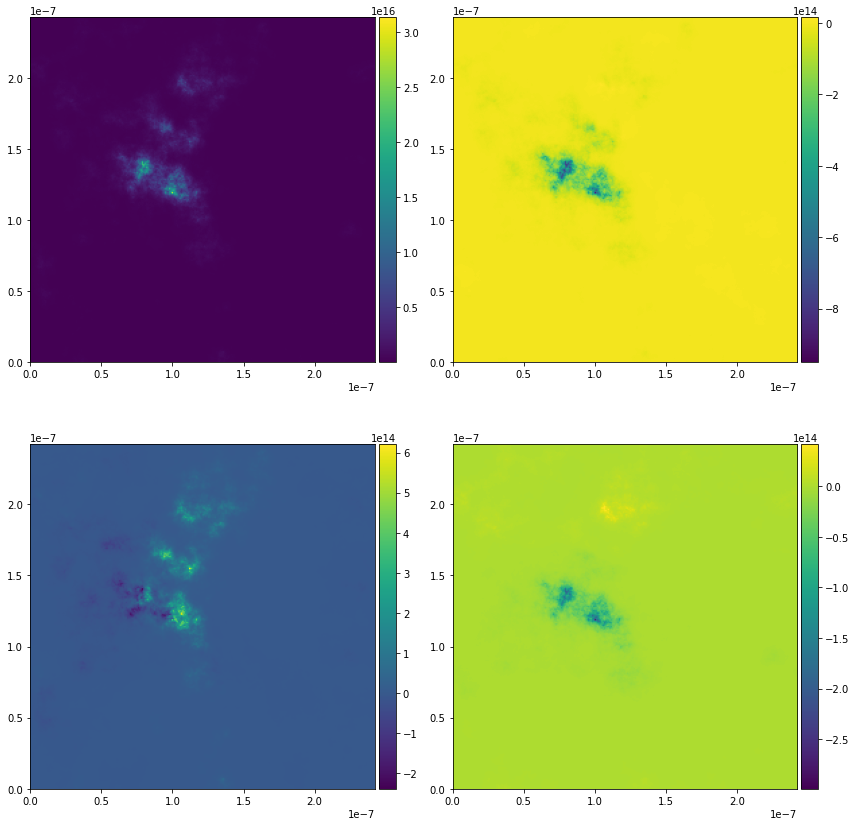

In [162]:
for ii in range(3):
    print(f"Stokes I, Q, U, and V priors {ii+1}")
    ift.single_plot(sky(ift.from_random(sky.domain)))

### Polarization calibration and imaging likelihood

In [163]:
do_wgridding = cfg["base"].getboolean("do_wgridding")
epsilon = cfg["base"].getfloat("epsilon")
gaincal = cfg["gain_logamplitude"].getboolean("gaincal")
Const_Dterm = cfg["Dterm_logamplitude"]["Const_Dterm"]

In [167]:
logamp_RCP_, logamp_LCP_, phase_RCP_, phase_LCP_ = gain_ops(cfg, obs, gaincal=gaincal)

if Const_Dterm == "False":
    Dterm_logamp_, Dterm_phase_ = Dterm_ops(cfg, obs)
if Const_Dterm == "True":
    Const_Dterm_logamp_RCP_, Const_Dterm_logamp_LCP_, Const_Dterm_phase_RCP_, Const_Dterm_phase_LCP_ = Const_Dterm_ops(cfg, obs)

BeginTime_UTC_list, timestamp = get_BeginTime_UTC(cfg)
field_rotation_angle_field = get_field_rotation_angle_field(cfg, obs, BeginTime_UTC_list, timestamp)

pol_cal_op_RR_ = pol_cal_op_RR(cfg, obs, logamp_RCP_, phase_RCP_, Const_Dterm_logamp_RCP_, Const_Dterm_phase_RCP_, field_rotation_angle_field, parang_corrected=parang_corrected)
pol_cal_op_RL_ = pol_cal_op_RL(cfg, obs, logamp_RCP_, logamp_LCP_, phase_RCP_, phase_LCP_, Const_Dterm_logamp_RCP_, Const_Dterm_logamp_LCP_, Const_Dterm_phase_RCP_, Const_Dterm_phase_LCP_, field_rotation_angle_field, parang_corrected=parang_corrected)
pol_cal_op_LR_ = pol_cal_op_LR(cfg, obs, logamp_RCP_, logamp_LCP_, phase_RCP_, phase_LCP_, Const_Dterm_logamp_RCP_, Const_Dterm_logamp_LCP_, Const_Dterm_phase_RCP_, Const_Dterm_phase_LCP_, field_rotation_angle_field, parang_corrected=parang_corrected)
pol_cal_op_LL_ = pol_cal_op_LL(cfg, obs, logamp_LCP_, phase_LCP_, Const_Dterm_logamp_LCP_, Const_Dterm_phase_LCP_, field_rotation_angle_field, parang_corrected=parang_corrected)

#response function
R = rve.InterferometryResponse(
    obs,
    sky.target,
    do_wgridding=False,
    epsilon=epsilon
)

#likelihood
Likelihood, Rs_pol = PolarizationLikelihood(obs, R, sky, pol_cal_op_RR_, pol_cal_op_RL_, pol_cal_op_LR_, pol_cal_op_LL_)

Work on Field 0: 1226+023


### Minimization

In [168]:
cfg_optimization = cfg["optimization"]
ic_sampling_iter_lim = cfg_optimization.getint("ic_samplilng_iter_lim")
ic_VL_BFGS_iter_lim_1 = cfg_optimization.getint("ic_VL_BFGS_iter_lim_1")
ic_VL_BFGS_iter_lim_2 = cfg_optimization.getint("ic_VL_BFGS_iter_lim_2")
ic_newton_iter_lim_3 = cfg_optimization.getint("ic_newton_iter_lim_3")
ic_newton_iter_lim_4 = cfg_optimization.getint("ic_newton_iter_lim_4")
ic_sampling_nl_iter_lim = cfg_optimization.getint("ic_sampling_nl_iter_lim")
n_iterations = cfg_optimization.getint("n_iterations")
n_samples_ = cfg_optimization.getint("n_samples")
output_directory = cfg_optimization["output_directory"]


ic_sampling = ift.AbsDeltaEnergyController(deltaE=0.05, iteration_limit=ic_sampling_iter_lim)
ic_VL_BFGS_1 = ift.AbsDeltaEnergyController(name="VL_BFGS_1", deltaE=0.5,
                                         convergence_level=2, iteration_limit=ic_VL_BFGS_iter_lim_1)
ic_VL_BFGS_2 = ift.AbsDeltaEnergyController(name="VL_BFGS_2", deltaE=0.5,
                                         convergence_level=2, iteration_limit=ic_VL_BFGS_iter_lim_2)
ic_newton_3 = ift.AbsDeltaEnergyController(name="Newton_3", deltaE=0.5,
                                         convergence_level=2, iteration_limit=ic_newton_iter_lim_3)
ic_newton_4 = ift.AbsDeltaEnergyController(name="Newton_4", deltaE=0.5,
                                         convergence_level=2, iteration_limit=ic_newton_iter_lim_4)
ic_sampling_nl = ift.AbsDeltaEnergyController(name='Sampling (nonlin)',
                                              deltaE=0.5, iteration_limit=ic_sampling_nl_iter_lim,
                                              convergence_level=2)
minimizer_1 = ift.VL_BFGS(ic_VL_BFGS_1)
minimizer_2 = ift.VL_BFGS(ic_VL_BFGS_2)
minimizer_3 = ift.NewtonCG(ic_newton_3)
minimizer_4 = ift.NewtonCG(ic_newton_4)
minimizer = lambda iiter : minimizer_1 if iiter < 5 else minimizer_2 if iiter < 10 else minimizer_3 if iiter < 15 else minimizer_4
minimizer_sampling = ift.NewtonCG(ic_sampling_nl)

n_samples = lambda iiter: n_samples_ if iiter < 15 else 2 * n_samples_

print(f"Number of posterior samples: {4*n_samples_}") # if the number of samples is 0 : Maximum a posteriori (MAP) estimation

Number of posterior samples: 8


In [169]:
def inspect_callback(sl, iglobal):

    sky_posterior_mean = sl.average(sky)
    StokesI_sky = sky_posterior_mean.val.T[:, :, 0, 0, 0]
    StokesQ_sky = sky_posterior_mean.val.T[:, :, 0, 0, 1]
    StokesU_sky = sky_posterior_mean.val.T[:, :, 0, 0, 2]
    StokesV_sky = sky_posterior_mean.val.T[:, :, 0, 0, 3]
    Linear_pol = abs(StokesQ_sky + 1j * StokesU_sky)
    EVPA = np.rad2deg(0.5 * np.arctan2(StokesU_sky, StokesQ_sky))

    Dterm_posterior_mean_RCP = sl.average(np.exp(Const_Dterm_logamp_RCP_ + 1j * Const_Dterm_phase_RCP_))
    Dterm_posterior_mean_LCP = sl.average(np.exp(Const_Dterm_logamp_LCP_ + 1j * Const_Dterm_phase_LCP_))
    Dterm_posterior_mean_RCP = Dterm_posterior_mean_RCP.val[:,0]
    Dterm_posterior_mean_LCP = Dterm_posterior_mean_LCP.val[:,0]

    filename = f"{output_directory}/{output_directory}_Dterm_posterior_mean_{iglobal}.png"
    fig, ((ax1), (ax2)) = plt.subplots(2, 1, figsize=(6, 12))

    for ii in np.arange(int(len(uantennas))):
        ax1.scatter(Dterm_posterior_mean_RCP.real[ii], Dterm_posterior_mean_RCP.imag[ii],
                    label=f'{station_table[list(uantennas)[ii]]}')

    ax1.set_title('RCP Dterms', fontsize=15)
    ax1.set_xlabel('real')
    ax1.set_ylabel('imag')
    ax1.set_xlim(-0.5, 0.5)
    ax1.set_ylim(-0.5, 0.5)
    ax1.legend(loc='lower left')

    for ii in np.arange(int(len(uantennas))):
        ax2.scatter(Dterm_posterior_mean_LCP.real[ii], Dterm_posterior_mean_LCP.imag[ii],
                    label=f'{station_table[list(uantennas)[ii]]}')

    ax2.set_title('LCP Dterms', fontsize=15)
    ax2.set_xlabel('real')
    ax2.set_ylabel('imag')
    ax2.set_xlim(-0.5, 0.5)
    ax2.set_ylim(-0.5, 0.5)
    ax2.legend(loc='lower left')
    plt.savefig(filename)
    print(f"Saved results as {filename}.")
    plt.close()

    plt.imsave(f"{output_directory}/StokesI_sky_{iglobal}_logscale.png", np.log(StokesI_sky), origin="lower", cmap="inferno")
    if iglobal > 10:
        plt.imsave(f"{output_directory}/StokesQ_sky_{iglobal}.png", StokesQ_sky, origin="lower", cmap="bwr")
        plt.imsave(f"{output_directory}/StokesU_sky_{iglobal}.png", StokesU_sky, origin="lower", cmap="bwr")
        plt.imsave(f"{output_directory}/StokesV_sky_{iglobal}.png", StokesV_sky, origin="lower", cmap="bwr")
        plt.imsave(f"{output_directory}/Linear_pol_{iglobal}_logscale.png", np.log(Linear_pol), origin="lower", cmap="gist_rainbow")



In [146]:
samples = ift.optimize_kl(
    Likelihood,
    n_iterations,
    n_samples,
    minimizer,
    ic_sampling,
    None,
    export_operator_outputs={"sky":sky, "logamp_RCP":logamp_RCP_, "phase_RCP":phase_RCP_, "logamp_LCP":logamp_LCP_, "phase_LCP":phase_LCP_,
                             "Dterm_logamp_RCP":Const_Dterm_logamp_RCP_, "Dterm_phase_RCP":Const_Dterm_phase_RCP_,
                             "Dterm_logamp_LCP":Const_Dterm_logamp_LCP_, "Dterm_phase_LCP":Const_Dterm_phase_LCP_},
    output_directory=output_directory,
    inspect_callback=inspect_callback,
    resume=True
)

VL_BFGS_1: Iteration #0 energy=3.060216E+06 diff=3.060216E+06 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #1 energy=3.021214E+06 diff=3.900285E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #2 energy=3.000647E+06 diff=2.056639E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #3 energy=2.985911E+06 diff=1.473627E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #4 energy=2.976607E+06 diff=9.304251E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #5 energy=2.961662E+06 diff=1.494410E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #6 energy=2.941193E+06 diff=2.046900E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #7 energy=2.923316E+06 diff=1.787769E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #8 energy=2.899921E+06 diff=2.339438E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #9 energy=2.854427E+06 diff=4.549425E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #10 energy=2.793542E+06 diff=6.088503E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #11 energy=2.724117E+06 diff=6.942516E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Ite

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_0.png.


VL_BFGS_1: Iteration #0 energy=1.023124E+06 diff=1.023124E+06 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #1 energy=1.002468E+06 diff=2.065639E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #2 energy=9.707330E+05 diff=3.173490E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #3 energy=9.604631E+05 diff=1.026999E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #4 energy=9.559312E+05 diff=4.531853E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #5 energy=9.474408E+05 diff=8.490422E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #6 energy=9.315233E+05 diff=1.591748E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #7 energy=9.031801E+05 diff=2.834324E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #8 energy=8.589589E+05 diff=4.422120E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #9 energy=8.496651E+05 diff=9.293736E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #10 energy=8.325312E+05 diff=1.713394E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #11 energy=8.022125E+05 diff=3.031871E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Ite

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_1.png.


VL_BFGS_1: Iteration #0 energy=4.511736E+05 diff=4.511736E+05 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #1 energy=4.486149E+05 diff=2.558700E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #2 energy=4.456291E+05 diff=2.985781E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #3 energy=4.411216E+05 diff=4.507566E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #4 energy=4.375426E+05 diff=3.578910E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #5 energy=4.326652E+05 diff=4.877412E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #6 energy=4.244585E+05 diff=8.206776E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #7 energy=4.116955E+05 diff=1.276294E+04 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #8 energy=4.091787E+05 diff=2.516848E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #9 energy=4.047253E+05 diff=4.453324E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #10 energy=3.981694E+05 diff=6.555895E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #11 energy=3.952893E+05 diff=2.880115E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Ite

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_2.png.


VL_BFGS_1: Iteration #0 energy=3.329286E+05 diff=3.329286E+05 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #1 energy=3.320969E+05 diff=8.317082E+02 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #2 energy=3.298148E+05 diff=2.282124E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #3 energy=3.258151E+05 diff=3.999629E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #4 energy=3.196632E+05 diff=6.151956E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #5 energy=3.151270E+05 diff=4.536193E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #6 energy=3.120929E+05 diff=3.034132E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #7 energy=3.099459E+05 diff=2.147001E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #8 energy=3.066990E+05 diff=3.246892E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #9 energy=3.036998E+05 diff=2.999151E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #10 energy=3.009182E+05 diff=2.781649E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #11 energy=2.984800E+05 diff=2.438121E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Ite

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_3.png.


VL_BFGS_1: Iteration #0 energy=2.622159E+05 diff=2.622159E+05 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #1 energy=2.617714E+05 diff=4.445742E+02 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #2 energy=2.610264E+05 diff=7.450182E+02 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #3 energy=2.596879E+05 diff=1.338458E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #4 energy=2.574719E+05 diff=2.215952E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #5 energy=2.549400E+05 diff=2.531916E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #6 energy=2.535621E+05 diff=1.377975E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #7 energy=2.514338E+05 diff=2.128226E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #8 energy=2.506679E+05 diff=7.659346E+02 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #9 energy=2.493973E+05 diff=1.270574E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #10 energy=2.474758E+05 diff=1.921546E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Iteration #11 energy=2.448821E+05 diff=2.593669E+03 crit=5.0E-01 clvl=0
VL_BFGS_1: Ite

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_4.png.


VL_BFGS_2: Iteration #0 energy=2.303299E+05 diff=2.303299E+05 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #1 energy=2.301150E+05 diff=2.148716E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #2 energy=2.299858E+05 diff=1.291844E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #3 energy=2.297440E+05 diff=2.418463E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #4 energy=2.293098E+05 diff=4.341907E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #5 energy=2.285848E+05 diff=7.249678E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #6 energy=2.275558E+05 diff=1.029018E+03 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #7 energy=2.268040E+05 diff=7.517684E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #8 energy=2.261324E+05 diff=6.715972E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #9 energy=2.255215E+05 diff=6.109029E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #10 energy=2.250795E+05 diff=4.420313E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #11 energy=2.247469E+05 diff=3.326020E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Ite

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_5.png.


VL_BFGS_2: Iteration #0 energy=1.495211E+05 diff=1.495211E+05 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #1 energy=1.489940E+05 diff=5.271148E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #2 energy=1.485709E+05 diff=4.231323E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #3 energy=1.482672E+05 diff=3.037024E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #4 energy=1.480162E+05 diff=2.510301E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #5 energy=1.475449E+05 diff=4.712301E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #6 energy=1.466740E+05 diff=8.709629E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #7 energy=1.451644E+05 diff=1.509587E+03 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #8 energy=1.432371E+05 diff=1.927266E+03 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #9 energy=1.423234E+05 diff=9.136866E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #10 energy=1.415531E+05 diff=7.703168E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #11 energy=1.412286E+05 diff=3.244807E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Ite

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_6.png.


VL_BFGS_2: Iteration #0 energy=1.044709E+05 diff=1.044709E+05 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #1 energy=1.042266E+05 diff=2.443011E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #2 energy=1.040670E+05 diff=1.596485E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #3 energy=1.037686E+05 diff=2.983886E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #4 energy=1.032270E+05 diff=5.415516E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #5 energy=1.023547E+05 diff=8.722943E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #6 energy=1.014928E+05 diff=8.619097E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #7 energy=1.014219E+05 diff=7.094714E+01 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #8 energy=1.012962E+05 diff=1.256326E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #9 energy=1.010653E+05 diff=2.309037E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #10 energy=1.006352E+05 diff=4.301298E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #11 energy=9.985955E+04 diff=7.756577E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Ite

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_7.png.


VL_BFGS_2: Iteration #0 energy=7.970575E+04 diff=7.970575E+04 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #1 energy=7.963872E+04 diff=6.702889E+01 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #2 energy=7.957783E+04 diff=6.089019E+01 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #3 energy=7.946174E+04 diff=1.160979E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #4 energy=7.924521E+04 diff=2.165296E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #5 energy=7.886217E+04 diff=3.830376E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #6 energy=7.831024E+04 diff=5.519238E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #7 energy=7.815448E+04 diff=1.557668E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #8 energy=7.792154E+04 diff=2.329346E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #9 energy=7.769976E+04 diff=2.217861E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #10 energy=7.753658E+04 diff=1.631803E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #11 energy=7.731248E+04 diff=2.240971E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Ite

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_8.png.


VL_BFGS_2: Iteration #0 energy=5.969178E+04 diff=5.969178E+04 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #1 energy=5.952429E+04 diff=1.674968E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #2 energy=5.950366E+04 diff=2.062628E+01 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #3 energy=5.942784E+04 diff=7.581650E+01 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #4 energy=5.929549E+04 diff=1.323563E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #5 energy=5.908706E+04 diff=2.084315E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #6 energy=5.882224E+04 diff=2.648125E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #7 energy=5.853193E+04 diff=2.903103E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #8 energy=5.828085E+04 diff=2.510857E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #9 energy=5.786743E+04 diff=4.134159E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #10 energy=5.724092E+04 diff=6.265076E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Iteration #11 energy=5.647521E+04 diff=7.657136E+02 crit=5.0E-01 clvl=0
VL_BFGS_2: Ite

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_9.png.


Newton_3: Iteration #0 energy=5.150312E+04 diff=5.150312E+04 crit=5.0E-01 clvl=0
Iteration limit reached. Assuming convergence
Newton_3: Iteration #1 energy=5.074352E+04 diff=7.595950E+02 crit=5.0E-01 clvl=0
Newton_3: Iteration #2 energy=5.059920E+04 diff=1.443236E+02 crit=5.0E-01 clvl=0
Newton_3: Iteration #3 energy=3.862567E+04 diff=1.197353E+04 crit=5.0E-01 clvl=0
Newton_3: Iteration #4 energy=3.838194E+04 diff=2.437334E+02 crit=5.0E-01 clvl=0
Newton_3: Iteration #5 energy=3.662980E+04 diff=1.752144E+03 crit=5.0E-01 clvl=0
Newton_3: Iteration #6 energy=3.662530E+04 diff=4.499227E+00 crit=5.0E-01 clvl=0
Newton_3: Iteration #7 energy=3.200621E+04 diff=4.619087E+03 crit=5.0E-01 clvl=0
Newton_3: Iteration #8 energy=3.199983E+04 diff=6.378256E+00 crit=5.0E-01 clvl=0
Newton_3: Iteration #9 energy=2.803516E+04 diff=3.964668E+03 crit=5.0E-01 clvl=0
Newton_3: Iteration #10 energy=2.802815E+04 diff=7.018060E+00 crit=5.0E-01 clvl=0
Newton_3: Iteration #11 energy=2.784214E+04 diff=1.860103E+02 

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_10.png.


Newton_3: Iteration #0 energy=2.565686E+04 diff=2.565686E+04 crit=5.0E-01 clvl=0
Iteration limit reached. Assuming convergence
Newton_3: Iteration #1 energy=2.559648E+04 diff=6.038145E+01 crit=5.0E-01 clvl=0
Newton_3: Iteration #2 energy=2.559204E+04 diff=4.441050E+00 crit=5.0E-01 clvl=0
Newton_3: Iteration #3 energy=2.517922E+04 diff=4.128198E+02 crit=5.0E-01 clvl=0
Newton_3: Iteration #4 energy=2.517891E+04 diff=3.019598E-01 crit=5.0E-01 clvl=1
 Iteration limit reached. Assuming convergence
Newton_3: Iteration #5 energy=2.363236E+04 diff=1.546557E+03 crit=5.0E-01 clvl=0
Newton_3: Iteration #6 energy=2.360732E+04 diff=2.503745E+01 crit=5.0E-01 clvl=0
Newton_3: Iteration #7 energy=2.360135E+04 diff=5.966024E+00 crit=5.0E-01 clvl=0
Newton_3: Iteration #8 energy=2.350307E+04 diff=9.828593E+01 crit=5.0E-01 clvl=0
Newton_3: Iteration #9 energy=2.350268E+04 diff=3.835515E-01 crit=5.0E-01 clvl=1
 Iteration limit reached. Assuming convergence
Newton_3: Iteration #10 energy=2.194700E+04 diff=1

Saved results as 3C273_15GHz_polcal_results/3C273_15GHz_polcal_results_Dterm_posterior_mean_11.png.


Newton_3: Iteration #0 energy=1.958283E+04 diff=1.958283E+04 crit=5.0E-01 clvl=0
Iteration limit reached. Assuming convergence
Newton_3: Iteration #1 energy=1.953618E+04 diff=4.665340E+01 crit=5.0E-01 clvl=0
Newton_3: Iteration #2 energy=1.953444E+04 diff=1.738519E+00 crit=5.0E-01 clvl=0
Newton_3: Iteration #3 energy=1.907342E+04 diff=4.610211E+02 crit=5.0E-01 clvl=0
Newton_3: Iteration #4 energy=1.907331E+04 diff=1.086470E-01 crit=5.0E-01 clvl=1


KeyboardInterrupt: 

### Saving reconstructed Stokes images in fits


In [177]:
import h5py
import scipy

In [185]:
with h5py.File(f"{output_directory}/sky/last.hdf5", 'r') as hdf:
    if n_samples_ == 0:

        arr_sample0 = hdf['samples']['0']
        sky_MAP = ift.makeField(position_space, arr_sample0)
        sky_MAP_Jy_mas2 = sky_MAP / (180 / np.pi * 3600 * 1000) ** 2
        # ift.single_plot(sky_MAP)
        StokesI_sky = sky_MAP.val.T[:, :, 0, 0, 0]
        StokesQ_sky = sky_MAP.val.T[:, :, 0, 0, 1]
        StokesU_sky = sky_MAP.val.T[:, :, 0, 0, 2]
        StokesV_sky = sky_MAP.val.T[:, :, 0, 0, 3]
        StokesI_sky_Jy_mas2 = sky_MAP_Jy_mas2.val.T[:, :, 0, 0, 0]
        StokesQ_sky_Jy_mas2 = sky_MAP_Jy_mas2.val.T[:, :, 0, 0, 1]
        StokesU_sky_Jy_mas2 = sky_MAP_Jy_mas2.val.T[:, :, 0, 0, 2]
        StokesV_sky_Jy_mas2 = sky_MAP_Jy_mas2.val.T[:, :, 0, 0, 3]

        Linear_pol = abs(StokesQ_sky + 1j * StokesU_sky)
        Frac_linear_pol = Linear_pol / StokesI_sky
        EVPA = np.rad2deg(0.5 * np.arctan2(StokesU_sky, StokesQ_sky))

        # absolute EVPA correction for 2017_01_28 3C273
        if data_path == "Data/1226+023.u.2017_01_28_uvaver10_raw.ms" or "Data/MOJAVE_BL229AE_20170128/1226+023.u.2017_01_28_raw_edt_freqavg.ms":
            EVPA = EVPA - 35.5

        EVPA_rad = np.deg2rad(EVPA)
        EVPA_mask = EVPA_rad

        ### Fitsfile
        StokesI_sky_Jy_mas2_field = ift.makeField(sdom, StokesI_sky_Jy_mas2.T)
        StokesQ_sky_Jy_mas2_field = ift.makeField(sdom, StokesQ_sky_Jy_mas2.T)
        StokesU_sky_Jy_mas2_field = ift.makeField(sdom, StokesU_sky_Jy_mas2.T)
        rve.field2fits(StokesI_sky_Jy_mas2_field, f"{output_directory}/{output_directory}_StokesI_MGVI_{npix_x}_{npix_y}_Jy_mas2.fits", True, direction=obs.direction)
        rve.field2fits(StokesQ_sky_Jy_mas2_field, f"{output_directory}/{output_directory}_StokesQ_MGVI_{npix_x}_{npix_y}_Jy_mas2.fits", True, direction=obs.direction)
        rve.field2fits(StokesU_sky_Jy_mas2_field, f"{output_directory}/{output_directory}_StokesU_MGVI_{npix_x}_{npix_y}_Jy_mas2.fits", True, direction=obs.direction)

    else:
        sky_samplelist = []
        sky_arraylist = []
        for ii in np.arange(np.array(hdf["samples"]).size):
            arr_sample = hdf['samples'][f'{ii}']
            sky_array = np.array(arr_sample)

            sky_arraylist.append(sky_array)
            sky_sample = ift.makeField(position_space, arr_sample)
            sky_samplelist.append(sky_sample)


        sky_pos_mean = np.mean(sky_arraylist, axis=0)
        sky_pos_mean_Jy_mas2 = sky_pos_mean / (180 / np.pi * 3600 * 1000) ** 2
        StokesI_sky = sky_pos_mean.T[:, :, 0, 0, 0]
        StokesQ_sky = sky_pos_mean.T[:, :, 0, 0, 1]
        StokesU_sky = sky_pos_mean.T[:, :, 0, 0, 2]
        StokesV_sky = sky_pos_mean.T[:, :, 0, 0, 3]
        StokesI_sky_Jy_mas2 = sky_pos_mean_Jy_mas2.T[:, :, 0, 0, 0]
        StokesQ_sky_Jy_mas2 = sky_pos_mean_Jy_mas2.T[:, :, 0, 0, 1]
        StokesU_sky_Jy_mas2 = sky_pos_mean_Jy_mas2.T[:, :, 0, 0, 2]
        StokesV_sky_Jy_mas2 = sky_pos_mean_Jy_mas2.T[:, :, 0, 0, 3]

        linear_pol_posterior = []
        frac_linear_pol_posterior = []
        frac_circular_pol_posterior = []
        EVPA_posterior = []

        for index, sky_samples in enumerate(sky_samplelist):
            linear_pol_sample = abs(sky_samples.val.T[:, :, 0, 0, 1] + 1j * sky_samples.val.T[:, :, 0, 0, 2]) # P = |Q +iU|
            circular_pol_sample = sky_samples.val.T[:, :, 0, 0, 3] # Stokes V

            linear_pol_posterior.append(linear_pol_sample)
            frac_linear_pol_sample = linear_pol_sample / sky_samples.val.T[:, :, 0, 0, 0]
            frac_linear_pol_posterior.append(frac_linear_pol_sample)
            frac_circular_pol_sample = circular_pol_sample / sky_samples.val.T[:, :, 0, 0, 0]
            frac_circular_pol_posterior.append(frac_circular_pol_sample)

            EVPA_sample = np.rad2deg(0.5 * np.arctan2(sky_samples.val.T[:, :, 0, 0, 2], sky_samples.val.T[:, :, 0, 0, 1]))
            EVPA_posterior.append(EVPA_sample)


        Linear_pol_postmean = np.mean(linear_pol_posterior, axis=0)
        Linear_pol_postmean_Jy_mas2 = Linear_pol_postmean / (180 / np.pi * 3600 * 1000) ** 2

        Frac_linear_pol_postmean = np.mean(frac_linear_pol_posterior, axis=0)
        Frac_circular_pol_postmean = np.mean(frac_circular_pol_posterior, axis=0)
        EVPA_postmean = np.mean(EVPA_posterior, axis=0)
        EVPA_postmean_circmean = scipy.stats.circmean(EVPA_posterior, high=90.0, low=-90.0, axis=0)
        EVPA_poststd_circstd = scipy.stats.circstd(EVPA_posterior, high=90.0, low=-90.0, axis=0)
        

        # absolute EVPA correction for 2017_01_28 3C273
        if data_path == "Data/1226+023.u.2017_01_28_raw_edt.ms":
            EVPA_postmean = EVPA_postmean - 35.5

        EVPA_std = np.std(EVPA_posterior, axis=0)
        EVPA_std_nomask = np.std(EVPA_posterior, axis=0)
        EVPA_poststd_nomask_circstd = scipy.stats.circstd(EVPA_posterior, high=90.0, low=-90.0, axis=0)
        EVPA_rad = np.deg2rad(EVPA_postmean)
        EVPA_mask = EVPA_rad
        EVPA_rad_circmean = np.deg2rad(EVPA_postmean_circmean)
        EVPA_mask_circmean = EVPA_rad_circmean

        ### Fitsfile
        StokesI_sky_Jy_mas2_field = ift.makeField(sdom, StokesI_sky_Jy_mas2.T)
        StokesQ_sky_Jy_mas2_field = ift.makeField(sdom, StokesQ_sky_Jy_mas2.T)
        StokesU_sky_Jy_mas2_field = ift.makeField(sdom, StokesU_sky_Jy_mas2.T)
        EVPA_postmean_field = ift.makeField(sdom, EVPA_postmean.T)
        EVPA_std_field = ift.makeField(sdom, EVPA_std_nomask.T)
        EVPA_postmean_field_circmean = ift.makeField(sdom, EVPA_postmean_circmean.T)
        EVPA_std_field_circstd = ift.makeField(sdom, EVPA_poststd_nomask_circstd.T)
        Linear_pol_postmean_Jy_mas2_field = ift.makeField(sdom, Linear_pol_postmean_Jy_mas2.T)
        Frac_linear_pol_postmean_field = ift.makeField(sdom, Frac_linear_pol_postmean.T)

        rve.field2fits(StokesI_sky_Jy_mas2_field, f"{output_directory}/{output_directory}_StokesI_postmean_MGVI_{npix_x}_{npix_y}_Jy_mas2.fits", True, direction=obs.direction)
        rve.field2fits(StokesQ_sky_Jy_mas2_field, f"{output_directory}/{output_directory}_StokesQ_postmean_MGVI_{npix_x}_{npix_y}_Jy_mas2.fits", True, direction=obs.direction)
        rve.field2fits(StokesU_sky_Jy_mas2_field, f"{output_directory}/{output_directory}_StokesU_postmean_MGVI_{npix_x}_{npix_y}_Jy_mas2.fits", True, direction=obs.direction)
        rve.field2fits(EVPA_postmean_field_circmean, f"{output_directory}/{output_directory}_EVPA_postmean_MGVI_{npix_x}_{npix_y}_circmean_deg.fits", True, direction=obs.direction)
        rve.field2fits(EVPA_std_field_circstd, f"{output_directory}/{output_directory}_EVPA_std_MGVI_{npix_x}_{npix_y}_circstd_deg.fits", True, direction=obs.direction)
        rve.field2fits(Linear_pol_postmean_Jy_mas2_field, f"{output_directory}/{output_directory}_Linear_pol_postmean_MGVI_{npix_x}_{npix_y}_Jy_mas2.fits", True, direction=obs.direction)

/tmp/ipykernel_11519/1207042789.py:41: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  sky_array = np.array(arr_sample)
